# Netflix Movie Recommendation System

## Overview
This project aims to build a recommendation system for Netflix movies using collaborative filtering and Pearson's R correlations. The dataset used is from the Netflix Prize Data, comprising movie ratings given by users.

## Import Libraries
In this section, essential libraries are imported for data manipulation, visualization, and collaborative filtering.

In [35]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import math
import pandas as pd
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


## Data Loading and Cleaning
* Here, the movie titles dataset is loaded, and a preview of the data is displayed.
* This section involves loading individual movie rating datasets and performing basic cleaning, including handling missing values and converting data types.

In [36]:
# Explore the dataset by loading movie titles
df_title = pd.read_csv('/kaggle/input/netflix-prize-data/movie_titles.csv',encoding = 'ISO-8859-1', on_bad_lines='skip', header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title['Year'] = df_title['Year'].astype('Int64')
df_title['Movie_Id'] = df_title['Movie_Id'].astype('Int64')
df_title.set_index('Movie_Id', inplace = True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW


In [37]:
# Load the 1st data table and clean the NaN
df1 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_1.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df1['Movie_Id'] = df1['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df1['Movie_Id'] = df1['Movie_Id'].ffill()
df1 = df1.dropna()

df1['Cust_Id'] = df1['Cust_Id'].astype('Int64')
df1['Movie_Id'] = df1['Movie_Id'].astype('Int64')
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = pd.to_datetime(df1['Date'])

print('Dataset 1 shape: {}'.format(df1.shape))
print('Dataset examples')
display(df1)

Dataset 1 shape: (24053764, 4)
Dataset examples


,Cust_Id,Rating,Date,Movie_Id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1
...,...,...,...,...
24058258,2591364,2.0,2005-02-16,4499
24058259,1791000,2.0,2005-02-10,4499
24058260,512536,5.0,2005-07-27,4499
24058261,988963,3.0,2005-12-20,4499


In [ ]:
# 2nd dataset
df2 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_2.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df2['Movie_Id'] = df2['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df2['Movie_Id'] = df2['Movie_Id'].ffill()
df2 = df2.dropna()

df2['Movie_Id'] = df2['Movie_Id'].astype('Int64')
df2['Rating'] = df2['Rating'].astype(float)
df2['Date'] = pd.to_datetime(df2['Date'])
display(df2)

In [ ]:
# 3rd dataset
df3 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_3.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df3['Movie_Id'] = df3['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df3['Movie_Id'] = df3['Movie_Id'].ffill()
df3 = df3.dropna()

df3['Movie_Id'] = df3['Movie_Id'].astype('Int64')
df3['Rating'] = df3['Rating'].astype(float)
df3['Date'] = pd.to_datetime(df3['Date'])
display(df3)

In [ ]:
# 4th dataset
df4 = pd.read_csv('/kaggle/input/netflix-prize-data/combined_data_4.txt',header = None, names = ['Cust_Id','Rating','Date'], sep = ',')
df4['Movie_Id'] = df4['Cust_Id'].apply(lambda x: str(x).split(":")[0] if ':' in str(x) else None)
df4['Movie_Id'] = df4['Movie_Id'].ffill()
df4 = df4.dropna()

df4['Movie_Id'] = df4['Movie_Id'].astype('Int64')
df4['Rating'] = df4['Rating'].astype(float)
df4['Date'] = pd.to_datetime(df4['Date'])
display(df4)

## Exploratory Data Analysis (EDA)
This part explores the distribution of ratings in the dataset using a countplot.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Rating', ylabel='count'>

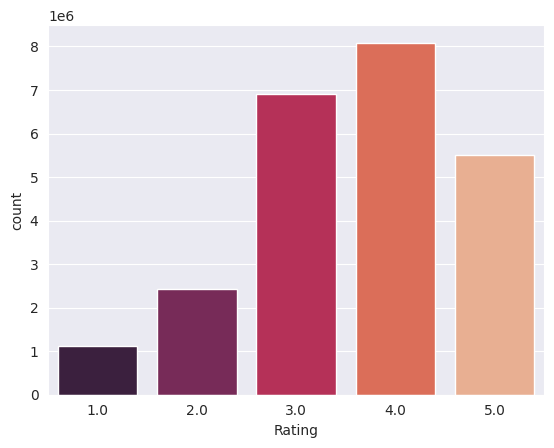

In [43]:
#EDA of the dataset
df = df1
# get movie count
movie_count = df['Movie_Id'].nunique()

# get customer count
cust_count = df['Cust_Id'].nunique() 

# get rating count
rating_count = df['Cust_Id'].count() 
sns.countplot(data = df, x = 'Rating', palette ='rocket')

## Data Reduction
This part reduces the dataset size by trimming less popular movies and less active customers.
The benchmark is set at 70th of the rating. 
We will remove the movie with rating less than the benchmark 

Besides, we will remove the data from user who have few review than the 70th of the review count for each user.

In [46]:
df = df1
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))


print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
display(df)

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0
Original Shape: (24053764, 4)
After Trim Shape: (17337458, 4)
-Data Examples-


,Cust_Id,Rating,Date,Movie_Id
696,712664,5.0,2004-02-01,3
697,1331154,4.0,2004-07-03,3
698,2632461,3.0,2005-07-22,3
699,44937,5.0,2004-06-22,3
700,656399,4.0,2003-09-20,3
...,...,...,...,...
24056841,520675,3.0,2005-06-16,4496
24056842,1055714,5.0,2005-06-20,4496
24056843,2643029,4.0,2005-09-10,4496
24056845,1559566,3.0,2005-11-07,4496


## Movie Recomendation - Based on user's experience
This section recommends movies for a specific user (user ID: 1990901) using collaborative filtering SVD.

### Train SVD model

In [23]:
# Load the data to Reader and apply cross_val to the model prediction
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'])

# Fit the full dataset to SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

### Recommend movies for user_785314

In [63]:
# Movie the user like in the past:

df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314.head(10))

Movie_Id
57         Richard III
175     Reservoir Dogs
311            Ed Wood
329              Dogma
331        Chasing Amy
395      Captain Blood
788             Clerks
798               Jaws
907    Animal Crackers
985          The Mummy
Name: Name, dtype: object


In [65]:
# Let's predict which movies user 785314 would love to watch:

user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
user_785314 = user_785314.drop('Movie_Id', axis = 1)
user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

      Year                                Name  Estimate_Score
1252  1988                 Red Dwarf: Series 3        5.000000
3455  2000                  Coupling: Season 1        5.000000
2990  1990   The Simpsons: Treehouse of Horror        5.000000
4038  1999             The Simpsons: Bart Wars        5.000000
1525  1983                         Black Adder        5.000000
2067  1994              The Simpsons: Season 6        4.995377
2136  1991              The Simpsons: Season 3        4.971472
1765  2002         An Evening With Kevin Smith        4.938886
2022  2001  Buffy the Vampire Slayer: Season 6        4.912586
2180  1999            Black Adder Back & Forth        4.911050


## Movie Recommendation with Pearson's R Correlations
Here, movie recommendations based on Pearson's R correlations are provided for a specified movie title.

Feel free to explore and experiment with different movie titles and parameters to get personalized recommendations. Enjoy the movie recommendations!

In [68]:
# Create pivot table for machine learning
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
display(df_p)

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN


In [69]:
# Function using the PearsonR metric to recommend movie
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.loc[df_title['Name'] == movie_title].index[0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))
    

In [70]:
recommend("Spartan", 0)

For movie (Spartan)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                           Name  count     mean
 1.000000                                        Spartan  19018 3.167315
 0.443295                                      Inu-Yasha   1883 4.554434
 0.440073                Dragon Ball Z: Super Android 13   2426 3.428689
 0.418646 Neon Genesis Evangelion: The End of Evangelion   2375 3.911158
 0.382955                               Samurai Champloo   2000 4.467500
 0.360592       Captain Pantoja and the Special Services   1801 3.417546
 0.358655                                    Invader Zim   2216 4.142599
 0.357516                   Tremors 4: The Legend Begins   1862 3.051020
 0.349364                                     The Legend   3217 3.755051
 0.343303                                   The Legend 2   3820 3.149476
